# Comparison of NowcastPNN and benchmark models on randomly split and most recent data

## Randomly split data

In [127]:
%load_ext autoreload
%autoreload 3
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from train_utils import SubsetSampler as SS
from sklearn.model_selection import train_test_split as TTS
import torch
import random
import numpy as np
torch.use_deterministic_algorithms(True) # reproducibility

STATE = "SP"
WEEKS = False
TRIANGLE = True
PAST_UNITS = 40
MAX_DELAY = 40
RANDOM_SPLIT = True
SEED = 1234
DEVICE = "mps"

dataset = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE)
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dataset.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS: # could also do random split, for now last indices as test
        train_idcs, test_idcs = range(300), range(300, dataset.__len__())
        TEST_BATCH_SIZE = dataset.__len__() - 300
    else: 
        train_idcs, test_idcs = range(2133), range(2133, dataset.__len__())
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(SEED)
test_sampler = SS(test_idcs)
test_loader = DataLoader(dataset, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(SEED)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


In [128]:
%load_ext autoreload
%autoreload 3
from metrics import RIVM_to_dict, Epi_to_dict
import numpy as np

rivm_dict = RIVM_to_dict()
epi_dict = Epi_to_dict()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
import pandas as pd
test_dates = pd.read_csv("test_dates.csv")

Convert from dictionary per date to dictionary per level of same-day nowcast

In [130]:
from metrics import date_to_level_dict

levels_rivm = date_to_level_dict(rivm_dict)
levels_epi = date_to_level_dict(epi_dict)

In [131]:
## Save RIVM dict, so can be used after

import pickle
"""
with open('../data/model_predictions/rivm_dict.pkl', 'wb') as f:
    pickle.dump(levels_rivm, f)

with open('../data/model_predictions/rivm_dict.pkl', 'wb') as f:
    pickle.dump(levels_epi, f)"""

"\nwith open('../data/model_predictions/rivm_dict.pkl', 'wb') as f:\n    pickle.dump(levels_rivm, f)\n\nwith open('../data/model_predictions/rivm_dict.pkl', 'wb') as f:\n    pickle.dump(levels_epi, f)"

In [132]:
with open('../data/model_predictions/nowcast_pnn_dict_dow.pkl', 'rb') as f:
    levels_pnn = pickle.load(f)


Go back to alt structure bc had 540 on random split, so even better

In [133]:
%load_ext autoreload
%autoreload 3
from metrics import evaluate_PIs

print("------ RIVM model ------")
rivm_score_dict = evaluate_PIs(levels_rivm, test_loader)
print("------ Epinowcast model ------")
epi_score_dict = evaluate_PIs(levels_epi, test_loader)
print("------ NowcastPNN model ------")
pnn_score_dict = evaluate_PIs(levels_pnn, test_loader)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
------ RIVM model ------
Actual coverage per level | 5%: 5.49 | 10%: 9.7 | 25%: 23.07 | 50%: 46.27 | 75%: 68.07 | 90%: 84.53 | 95%: 89.03 |
PICA: 0.03544303797468355
WIS: 250.3374279725725
IS: under = 202.0171220362204 | spread = 472.79753867791845 | over = 106.60153665927594 | total = 781.4161973734148
------ Epinowcast model ------
Actual coverage per level | 5%: 6.61 | 10%: 12.52 | 25%: 26.72 | 50%: 49.09 | 75%: 73.14 | 90%: 86.22 | 95%: 91.84 |
PICA: 0.02224231464737792
WIS: 305.22665527302786
IS: under = 59.89825125401408 | spread = 589.2480861965039 | over = 300.84916581185735 | total = 949.9955032623753
------ NowcastPNN model ------
Actual coverage per level | 5%: 5.06 | 10%: 9.56 | 25%: 24.05 | 50%: 49.09 | 75%: 71.73 | 90%: 84.67 | 95%: 89.17 |
PICA: 0.02399035563592525
WIS: 178.90852636582468
IS: under = 130.26896707309768 | spread = 347.8920283303195 | over = 92.21552357217467 | total = 

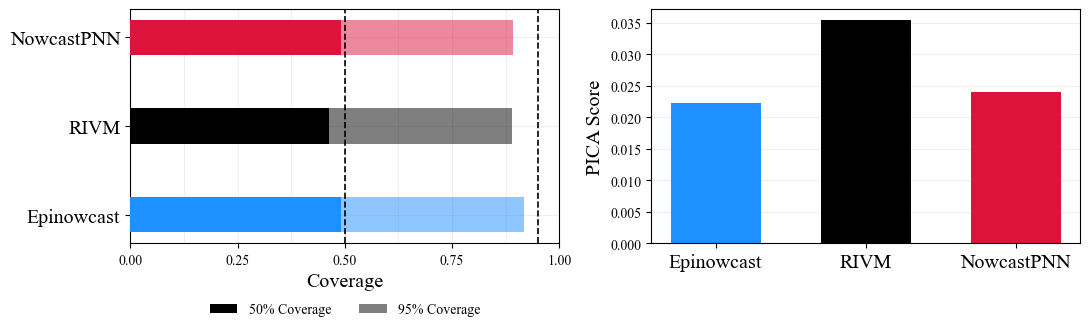

In [134]:
from plotting import plot_coverages_pica
plot_coverages_pica(epi_dict=epi_score_dict, rivm_dict=rivm_score_dict, pnn_dict=pnn_score_dict, save = True, random_split=RANDOM_SPLIT)

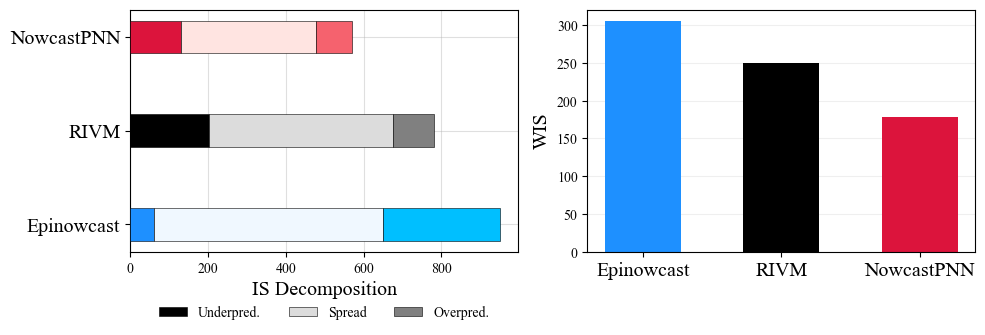

In [135]:
from plotting import plot_is_decomp_wis
plot_is_decomp_wis(epi_score_dict=epi_score_dict, rivm_score_dict=rivm_score_dict, pnn_score_dict=pnn_score_dict, save=True, random_split=RANDOM_SPLIT)

## For most recent dates as test set

In [11]:
RANDOM_SPLIT = False
dataset = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE)
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dataset.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS: # could also do random split, for now last indices as test
        train_idcs, test_idcs = range(300), range(300, dataset.__len__())
        TEST_BATCH_SIZE = dataset.__len__() - 300
    else: 
        train_idcs, test_idcs = range(2133), range(2133, dataset.__len__())
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(SEED)
test_sampler = SS(test_idcs)
test_loader = DataLoader(dataset, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(path, index_col=0)#pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


In [69]:
from metrics import RIVM_to_dict, date_to_level_dict, postprocess_rivm_level
rivm_dict = RIVM_to_dict(path= "../data/model_predictions/RIVM_list_recent.json")
levels_rivm = date_to_level_dict(rivm_dict)
levels_rivm = postprocess_rivm_level(levels_rivm)
epi_dict = Epi_to_dict(path= "../data/model_predictions/epinowcast_list_recent.json")
levels_epi = date_to_level_dict(epi_dict)
with open('../data/model_predictions/nowcast_pnn_dict_recent_dow.pkl', 'rb') as f:
    levels_pnn = pickle.load(f)

Also re-run model and save best weights, make sure not overwritten in experiments, keep best-performing ones

In [70]:
from metrics import evaluate_PIs

print("------ RIVM model ------")
rivm_score_dict = evaluate_PIs(levels_rivm, test_loader)
print("------ Epinowcast model ------")
epi_score_dict = evaluate_PIs(levels_epi, test_loader)
print("------ NowcastPNN model ------")
pnn_score_dict = evaluate_PIs(levels_pnn, test_loader)

------ RIVM model ------
Actual coverage per level | 5%: 5.34 | 10%: 9.0 | 25%: 22.93 | 50%: 44.87 | 75%: 66.67 | 90%: 82.28 | 95%: 87.9 |
PICA: 0.045288326300984526
WIS: 313.4214658136002
IS: under = 298.82036196915163 | spread = 541.4175155716295 | over = 134.1247845351776 | total = 974.3626620759587
------ Epinowcast model ------
Actual coverage per level | 5%: 6.19 | 10%: 11.81 | 25%: 26.02 | 50%: 48.38 | 75%: 70.75 | 90%: 87.9 | 95%: 92.83 |
PICA: 0.020233072131806314
WIS: 357.8707966239242
IS: under = 91.64154878523077 | spread = 657.7897528631705 | over = 362.7116219992081 | total = 1112.1429236476092
------ NowcastPNN model ------
Actual coverage per level | 5%: 6.47 | 10%: 11.95 | 25%: 28.69 | 50%: 52.88 | 75%: 74.82 | 90%: 88.75 | 95%: 92.41 |
PICA: 0.020032147880249134
WIS: 224.7632133591323
IS: under = 220.0176061344171 | spread = 368.3028782399036 | over = 107.23904580955436 | total = 695.559530183875


### Plot coverages and PICA Score

Side by side, so can be imported directly, share same font size etc.

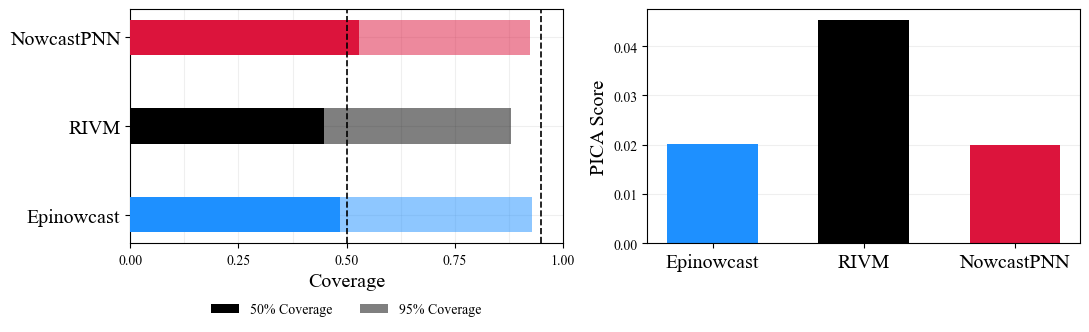

In [74]:
from plotting import plot_coverages_pica
plot_coverages_pica(epi_dict=epi_score_dict, rivm_dict=rivm_score_dict, pnn_dict=pnn_score_dict, save = True, random_split=RANDOM_SPLIT)

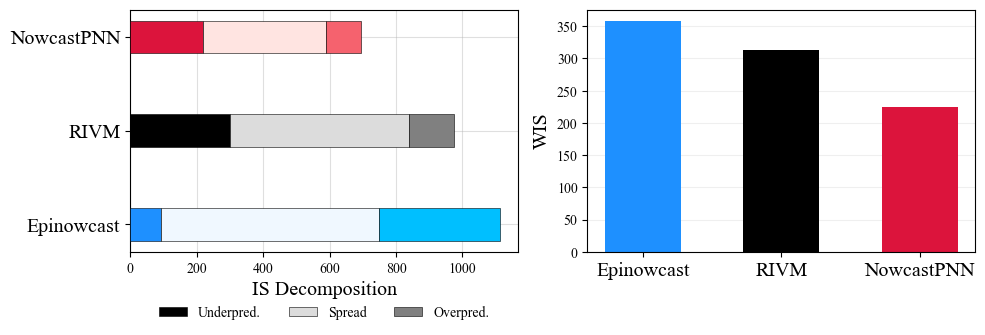

In [73]:
from plotting import plot_is_decomp_wis
plot_is_decomp_wis(epi_score_dict=epi_score_dict, rivm_score_dict=rivm_score_dict, pnn_score_dict=pnn_score_dict, save=True, random_split=RANDOM_SPLIT)

Zoom in around "2018-12-23" - "2019-07-11"

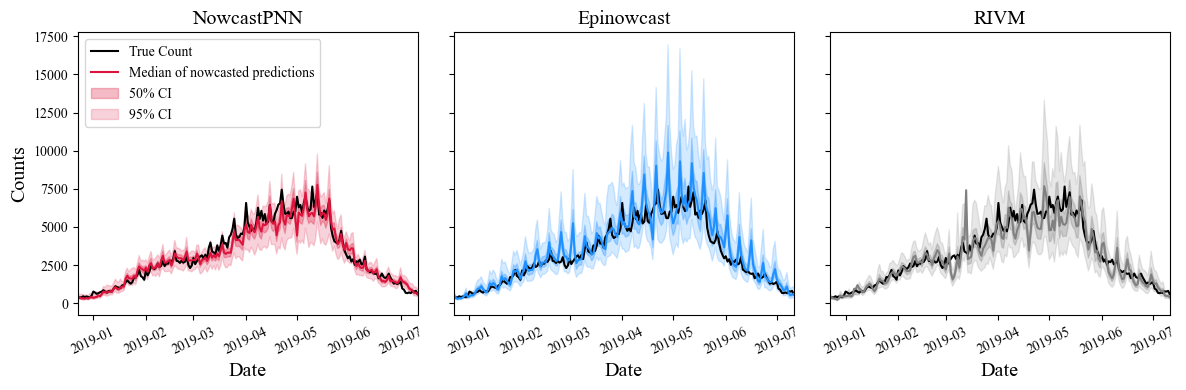

In [125]:
from plotting import plot_sameday_nowcast_recent
plot_sameday_nowcast_recent(test_loader=test_loader, test_idcs=test_idcs, levels_pnn=levels_pnn, levels_epi=levels_epi, levels_rivm=levels_rivm, xlims = ["2018-12-23", "2019-07-11"], save = True)

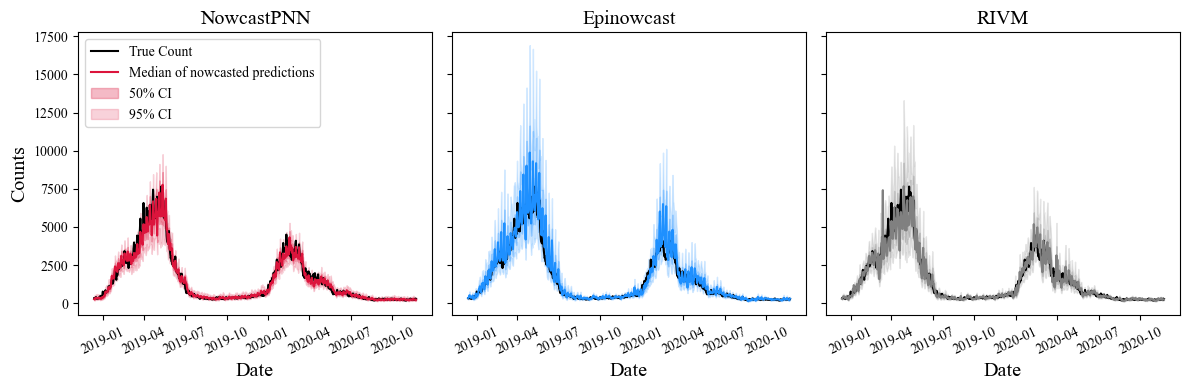

In [126]:
plot_sameday_nowcast_recent(test_loader=test_loader, test_idcs=test_idcs, levels_pnn=levels_pnn, levels_epi=levels_epi, levels_rivm=levels_rivm, save = True)